# This notebook aims to make a display of all data retrieved in ADCP EC150 files with plots equivalents to EK80 GUI 


## import some libraries

In [1]:
%matplotlib inline

import netCDF4  as nc
import math
import numpy as np
import matplotlib.pyplot as plt


ImportError: No module named netCDF4

## Set file path

In [ ]:
base_path="L://ADCP_EC150//essais_CGFS//SIMRAD//NETCDF//"
filename="CGFS19-D20190917-T143641.nc"
file_path= base_path + filename

## ADCP reader, open the file and manage its variable access


In [ ]:
class ADCPReader():
    """
    Class used for reading a ADCP file
    """
    def __init__(self, filename):
        # open the file
        self.file_name = filename
        self.dataset = nc.Dataset(self.file_name)
        self.ignore_variable = ["NMEA_datagram", "time", "annotation_text", "annotation_category", "beam"]
        self.beamGroup = self.dataset["/Sonar/Beam_group1"]

        ping_count = self.dataset["/Sonar/"].dimensions["ping_time"]
        self.ping_count = ping_count.size

        beam_count = self.beamGroup.dimensions["beam"]
        self.beam_count = beam_count.size

    def __del__(self):
        # close the file
        self.dataset.close()

## Function to print file variables names

In [ ]:

def print_file_variables_path(reader, group, index):
    for variable in sorted(group.variables):
        vname = group[variable]._grp.path + "/" + variable
        print(vname)
    for subgroup_name in group.groups:
        print_file_variables_path(reader, group.groups[subgroup_name], index)


## function to compute and retrieve a matrix of ping indexed variables (like current_velocity_vessel_y)

In [ ]:
def get_1d_vlen(vname):
    """
       compute and retrieve a matrix of ping indexed variables (like current_velocity_vessel_y)
       """
    vlen_variable = reader.dataset[vname]
    shape = vlen_variable.shape
    # retrieve max size
    max_samples = 0
    if not len(shape) == 1:
        raise Exception("This function shall be called only for vlen ping indexed variable ")

    # initialize ping (with nans)\n",
    for ping in range(0, reader.ping_count):
        sub_array = vlen_variable[ping]
        max_samples = max(max_samples, len(sub_array))

    # fill ping with data\n",
    matrix = np.full((shape[0], max_samples), dtype='float32', fill_value=float(np.nan))
    for ping in range(reader.ping_count):
        # Warning, auto scale if set by default ping[bnr][:count] = sample_amplitude[start:stop]
        values = vlen_variable[ping]
        count = len(values)
        matrix[ping][:count] = values
    return matrix


## retrieve and compute a matrix of a slice of ping,beam vlen variables

In [ ]:
def get_2d_vlen_slice(vname,beam):
    """
    retrieve and compute a matrix of a slice of ping,beam vlen variables
    """
    vlen_variable = reader.dataset[vname]
    shape = vlen_variable.shape
    # retrieve max size
    max_samples = 0
    if not len(shape) == 2:
        raise Exception("This function shall be called only for ping,beam indexed variable ")

    # initialize ping (with nans)\n",
    for ping in range(0, reader.ping_count):
        sub_array = vlen_variable[ping][beam]
        max_samples = max(max_samples, len(sub_array))

    # fill ping with data\n",
    matrix = np.full((shape[0], max_samples), dtype='float32', fill_value=float(np.nan))
    for ping in range(reader.ping_count):
        # Warning, auto scale if set by default ping[bnr][:count] = sample_amplitude[start:stop]
        values = vlen_variable[ping][beam]
        count = len(values)
        matrix[ping][:count] = values
    return matrix


## Utilities function definition

In [ ]:

def read_and_plot_1Dvlen(vname):
   values=get_1d_vlen(vname)
   plot(vname,values)
    

def read_and_plot_2d_vlen_slice(vname,beam):
    values=get_2d_vlen_slice(vname,beam)
    plot(vname+"["+str(beam)+"]",np.transpose(values))

def plot(vname,values):
    print(">Variable : " + vname)
    print("\tstatistics min:" + str(np.nanmin(values)) + " max:" + str(np.nanmax(values)))
    #plt.figure()
    if len(values.shape) == 1:
        plt.plot(values)
    else:
        plt.imshow(np.transpose(values), aspect='auto', cmap=plt.get_cmap("jet"))
        plt.colorbar()
    plt.title(vname)
    plt.show()



## Really do the job

In [ ]:
reader= ADCPReader(file_path)
#print_file_variables_path(reader,reader.dataset,0)

read_and_plot_1Dvlen("/Sonar/Beam_group1/ADCP/current_velocity_vessel_x")
read_and_plot_1Dvlen("/Sonar/Beam_group1/ADCP/current_velocity_vessel_y")
read_and_plot_1Dvlen("/Sonar/Beam_group1/ADCP/current_velocity_vessel_z")


read_and_plot_1Dvlen("/Sonar/Beam_group1/ADCP/current_velocity_geographical_down")
read_and_plot_1Dvlen("/Sonar/Beam_group1/ADCP/current_velocity_geographical_north")
read_and_plot_1Dvlen("/Sonar/Beam_group1/ADCP/current_velocity_geographical_east")
 


read_and_plot_2d_vlen_slice("/Sonar/Beam_group1/backscatter_r",0)
read_and_plot_2d_vlen_slice("/Sonar/Beam_group1/backscatter_r",1)
read_and_plot_2d_vlen_slice("/Sonar/Beam_group1/backscatter_r",2)
read_and_plot_2d_vlen_slice("/Sonar/Beam_group1/backscatter_r",3)

## compute Sv level
$S_v=10log_{10}(P_r)+20 log_{10}(r)+2{\alpha}r - 10 log_{10}(\frac{P_t\lambda^2c\psi\tau_e}{32\pi^2})-2G -40log_{10}(cos(\gamma))$

In [9]:
#check celerity

#check celerity
c=reader.dataset["/Environment/sound_speed_indicative"]
celerity = np.asarray(c)
if math.isnan(celerity) or celerity<=0:
    #use default value
    celerity=1480
print(celerity)

1480


0.006868166666666665

>Variable : Pr
	statistics min:-164.19136 max:4.3590565


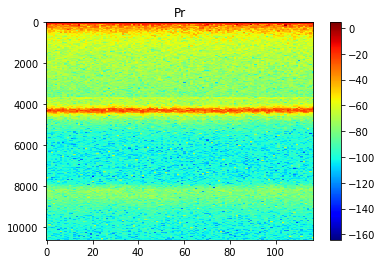

In [10]:
# Pr is the square magnitude of backscatter
br=get_2d_vlen_slice("/Sonar/Beam_group1/backscatter_r",0)
bi=get_2d_vlen_slice("/Sonar/Beam_group1/backscatter_i",0)
nominalTransducerImpedance  = 75;
wbtImpedanceRx              = 5e3; 
powerFactor=0.5*((wbtImpedanceRx+nominalTransducerImpedance)/wbtImpedanceRx)**2 * 1/nominalTransducerImpedance
display(powerFactor)
Pr=(br*br+bi*bi) * 0.0625 * powerFactor*1e-6
plot("Pr",10*np.log10(Pr))

>Variable : range
	statistics min:0.0 max:196.13699504516262


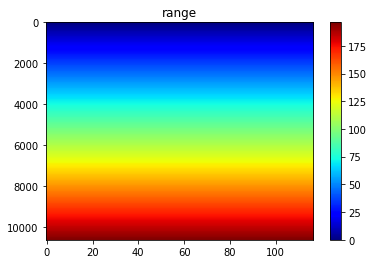

In [11]:
#compute the range of each sample
number_of_sample=br.shape[1]
indexes=np.arange(0,number_of_sample)
sample_interval=reader.dataset["/Sonar/Beam_group1/sample_interval"]
sample_interval=np.asarray(sample_interval)

#hack because sample interval is filled with 0
sample_interval=sample_interval+2.5e-05

temp=np.reshape(sample_interval,(sample_interval.shape[0],1))*np.reshape(indexes,(1,indexes.shape[0]))

sample_time_offset=reader.dataset["/Sonar/Beam_group1/sample_time_offset"]
blanking_interval=reader.dataset["/Sonar/Beam_group1/blanking_interval"]
offset=sample_time_offset[:]-blanking_interval[:]
offset=offset.reshape(offset.shape[0],1)
range=(0.5*celerity)*(temp-offset)
plot("range",range)

In [12]:
#compute absorption
absorption=50/1000
#missing value in file


>Variable : Pt
	statistics min:200.0 max:200.0


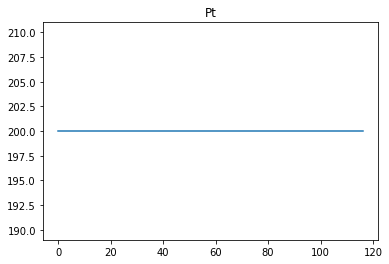

In [13]:
#transmit power per ping
Pt=reader.dataset["/Sonar/Beam_group1/transmit_power"]
plot("Pt",Pt)

>Variable : Lambda
	statistics min:0.009866667 max:0.009866667


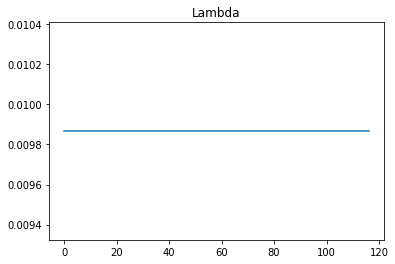

In [14]:

#acoustic wave length
FqStart=reader.dataset["/Sonar/Beam_group1/transmit_frequency_start"]
FqStop=reader.dataset["/Sonar/Beam_group1/transmit_frequency_stop"]
FqMean=0.5*np.abs(FqStop[:]+FqStart[:])

lambda_ = np.divide(celerity,FqMean)
plot("Lambda",lambda_)

>Variable : Te
	statistics min:0.0030792016 max:0.0030792016


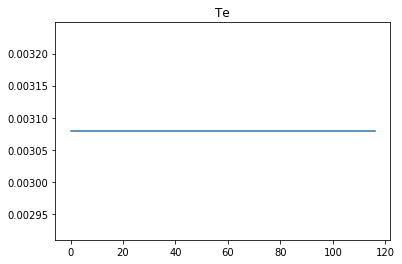

In [15]:
#compute effective pulse duration
Te=reader.dataset["/Sonar/Beam_group1/transmit_duration_equivalent"]
plot("Te",Te)

>Variable : Psi
	statistics min:-30.5 max:-30.5


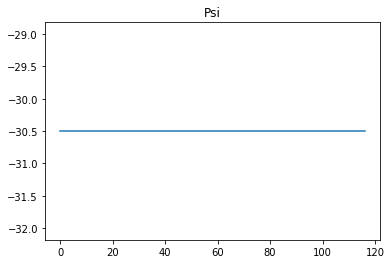

In [16]:

#compute psi
psi=reader.dataset["/Sonar/Beam_group1/equivalent_beam_angle"]
psi=np.asarray(psi)

#use default value
psi=psi-30.5
    
plot("Psi",psi[:,0])
# only care (in first approach) about beam 0
psi=psi[:,0]

>Variable : Gain beam 0
	statistics min:35.7 max:35.7


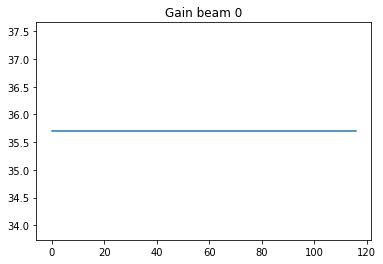

In [17]:

#compute Gain
G= reader.dataset["/Sonar/Beam_group1/transducer_gain"]
G=np.asarray(G)

#use default value
G=G+35.7

plot("Gain beam 0",G[:,0])
# only care (in first approach) about beam 0
G=G[:,0]

In [18]:

#HACK do we care about gamma ?
#cos gamma is the dot product of the beam vector and the vertical vector in the sonar beam coordinate system


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


>Variable : Sv
	statistics min:-147.4217674480862 max:-16.14097456556233


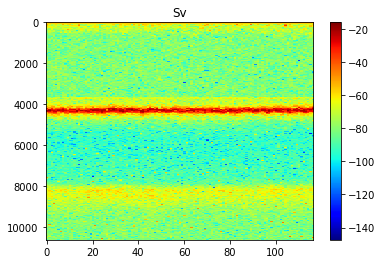

In [19]:

# Compute Sv, only care (in first approach) about beam 0

const_coef=celerity/(32*math.pow(math.pi,2))
interm=10*np.log10(Pt*np.power(2,lambda_)*const_coef*Te)+psi+2*G
interm=np.reshape(interm,(interm.shape[0],1))
Sv= 10*np.log10(Pr)+20*np.log10(range)+2*absorption*range-interm
plot("Sv",Sv)